# Analyzing player behavior to predict usage of a Minecraft research server

## Introduction

### Background

Minecraft is a sandbox, open-world video game developed by Mojang Studios where players explore, build and interact in a three-dimensional virtual world made of blocks. Players can build structures, gather resources and craft items to aid their survival, either individually or with other players in a multiplayer server (Minecraft.net, 2023). This makes it an ideal platform for studying player behaviors in a video game.

A research group led by Professor Frank Wood wants to assess how people play video games. To do this, they have set up a Minecraft server where players' interactions are recorded in detailed session logs. However, in doing so they face challenges such as identifying which players are most valuable to recruit and ensuring they have the resources necessary. Understanding period where most sessions are played is crucial in maintaining the scale of the research and minimizing the cost. Different time periods may contribute to the different amount of data, which leads to requiring levels of technical support, and placing different demands on valuable resources during those time periods. By identifying the different time periods through clustering analysis, research teams can ensure adequate resource management.

### Question

This project aims to answer the question: **Are there distinct time-of-day or day-of-week usage patterns to manage the resources spent for each time of the day or day of the week?**

### Data Description

We will be using the `sessions.csv` dataset provided by the research group to determine which time periods most valuable to optimize the resource management and ensure they have the resources necessary. 

The dataset is structured as follows:

1. `hasedEmail`: encrypted email for each player
2. `start_time`: start time of session
3. `end_time`: end time of session
4. `original_start_time`: computer tracked start time (number of seconds from Jan 1 1970)
5. `original_end_time`: computer tracked end time (number of seconds from Jan 1 1970)

This dataset contains **1535** unique sessions.

## Methods & Result

### Load data and wrangle data

1. To begin analysis, we need to load all the necessary libraries and import the datasets. Load the `sessions.csv` data and assign it to the object `sessions` using `read_csv`. Since we won't be using the original times and hasedEmail, we can remove those columns.
2. We need to parse the data from the dataset into the approproiate time format which is `day/month/year hour:minute`. We also need to seperate the session start times and end times into their respective day of the week and hour of the day.
3. Summarize the wrangled data to see if there any occuring pattern and distributions such as what time of day and which day of the week do most people play at.
4. View this summary through a visualization.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

sessions <- read.csv("data/sessions.csv") |> select(start_time, end_time)
head(sessions)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

,start_time,end_time
,<chr>,<chr>
1,30/06/2024 18:12,30/06/2024 18:24
2,17/06/2024 23:33,17/06/2024 23:46
3,25/07/2024 17:34,25/07/2024 17:57
4,25/07/2024 03:22,25/07/2024 03:58
5,25/05/2024 16:01,25/05/2024 16:12
6,23/06/2024 15:08,23/06/2024 17:10


In [18]:
sessions_clean <- sessions |>
  mutate(
    start_time = dmy_hm(start_time),  # Parse day/month/year hour:minute|
    start_time_day_of_week = wday(start_time, label = TRUE, abbr = FALSE),  # e.g., "Monday"
    start_time_hrs = hour(start_time) + minute(start_time)/60, # Convert to decimal hour
    end_time = dmy_hm(end_time),  # Parse day/month/year hour:minute
    end_time_day_of_week = wday(end_time, label = TRUE, abbr = FALSE),  # e.g., "Monday"
    end_time_hrs = hour(end_time) + minute(end_time)/60, # Convert to decimal hour
    session_duration_mins = as.numeric(difftime(end_time, start_time, units = "mins"))
  )
sessions_clean

start_time,end_time,start_time_day_of_week,start_time_hrs,end_time_day_of_week,end_time_hrs,session_duration_mins
<dttm>,<dttm>,<ord>,<dbl>,<ord>,<dbl>,<dbl>
2024-06-30 18:12:00,2024-06-30 18:24:00,Sunday,18.20000,Sunday,18.40000,12
2024-06-17 23:33:00,2024-06-17 23:46:00,Monday,23.55000,Monday,23.76667,13
2024-07-25 17:34:00,2024-07-25 17:57:00,Thursday,17.56667,Thursday,17.95000,23
⋮,⋮,⋮,⋮,⋮,⋮,⋮
2024-07-28 15:36:00,2024-07-28 15:57:00,Sunday,15.600000,Sunday,15.950000,21
2024-07-25 06:15:00,2024-07-25 06:22:00,Thursday,6.250000,Thursday,6.366667,7
2024-05-20 02:26:00,2024-05-20 02:45:00,Monday,2.433333,Monday,2.750000,19


In [19]:
sessions_clean |>
  mutate(hour_bin = floor(start_time_hrs)) |>
  count(hour_bin) |>
  arrange(desc(n))

sessions_clean |>
  group_by(start_time_day_of_week) |>
  summarise(
    total_duration = sum(session_duration_mins, na.rm = TRUE),
    average_duration = mean(session_duration_mins, na.rm = TRUE),
    num_sessions = n()
  ) |>
  arrange(desc(total_duration))  # Or use average_duration to sort differently

hour_bin,n
<dbl>,<int>
2,152
4,151
3,131
⋮,⋮
10,3
13,2
12,1


start_time_day_of_week,total_duration,average_duration,num_sessions
<ord>,<dbl>,<dbl>,<int>
Saturday,15441,59.16092,261
Sunday,14872,59.96774,249
Tuesday,10608,52.25616,204
⋮,⋮,⋮,⋮
Wednesday,9497,45.22381,210
Thursday,9019,40.44395,223
Monday,8803,42.52657,207


From the summary tables, we can see that most players played on Saturdays and most people prefer to play at around 2 AM.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


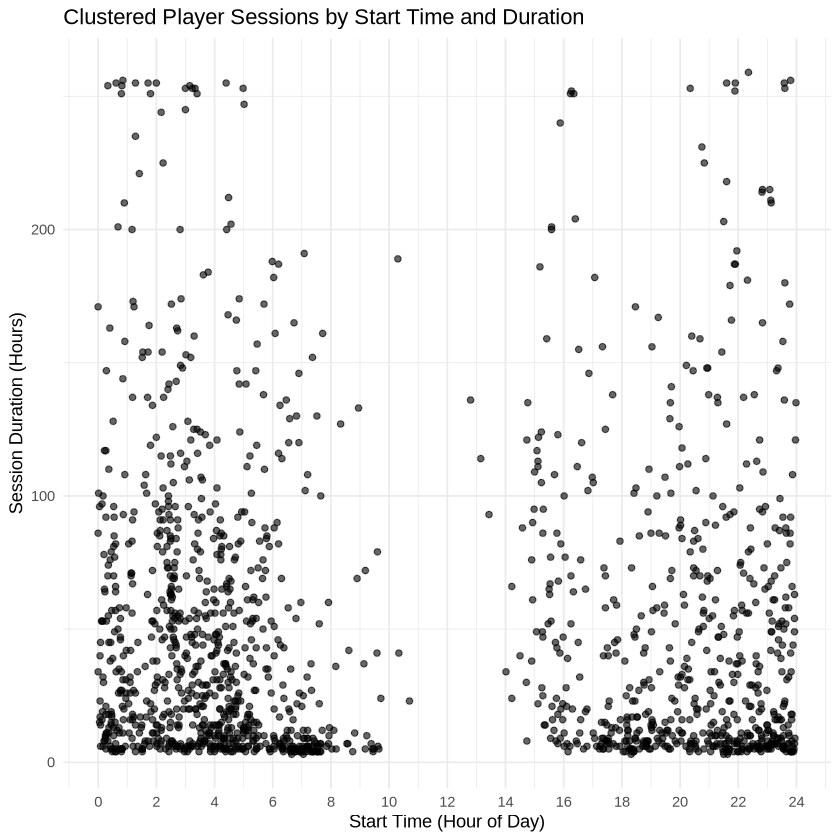

In [27]:
ggplot(sessions_clean, aes(x = start_time_hrs, y = session_duration_mins)) +
  geom_point(alpha = 0.6, size = 1.5) +
  scale_x_continuous(name = "Start Time (Hour of Day)", breaks = seq(0, 24, 2)) +
  scale_y_continuous(name = "Session Duration (Hours)") +
  labs(title = "Clustered Player Sessions by Start Time and Duration") +
  theme_minimal()

## Discussion

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Praesent vel ligula scelerisque, feugiat erat vel, tincidunt justo. Curabitur ac sapien nec justo tincidunt interdum. Integer nec libero nec nisi tincidunt vehicula. Fusce id velit ut libero pulvinar facilisis. Sed euismod, nisl eget consectetur fermentum, nisi libero ultricies nunc, nec tincidunt sapien eros nec libero. Nullam id felis ut elit tincidunt pharetra. Suspendisse potenti. Proin ac orci vel arcu tincidunt pharetra. Integer vel nisi nec justo dictum tincidunt ut ac purus.

## References

Landin, Per. “What is Minecraft.” Minecraft.net, 5 June 2023, www.minecraft.net/en-us/article/what-minecraft.

